In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


## 1. Library Imports

In [19]:
#Common imports
import time
from collections import Counter

# sklearn-specific data processing  imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#class balancing imports
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

# sklearn-specific model imports
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, \
                             RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
 
from sklearn.metrics import accuracy_score, f1_score, classification_report,\
                            ConfusionMatrixDisplay, confusion_matrix

from xgboost import XGBClassifier 

# Data visualization imports
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("dark")
plt.rcParams['figure.figsize'] = (18, 12)

In [20]:
#Choose which model to run
d = {1:"Log Reg", 2:"XGBoostClf", 3:"BaggingClassifier"}
print(d)
choose_model_seq = 1 # int(input("Choose model: "))
print("Chosen Model to Run: ",d[choose_model_seq])

{1: 'Log Reg', 2: 'XGBoostClf', 3: 'BaggingClassifier'}
Chosen Model to Run:  Log Reg


In [21]:
#Loading the training Data
df = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')

## EDA, Preprocessing and Feature Engineering

In [22]:
df.shape

(13636, 15)

In [23]:
#Quick summary of the training data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


*Few Observation based on df.info()*
> 1. There are 13636 rows with 15 columns including the target column.
> 2. There are 10 numerical features and 5 categorical features.
> 3. There are two null values in Recipe_Review column.

In [24]:
#Descriptive statistics of the training data
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,13636.0,NaN,NaN,NaN,121.085289,116.995633,0.0,45.0,91.0,148.0,724.0
RecipeNumber,13636.0,NaN,NaN,NaN,38.624377,29.672351,1.0,12.0,33.0,63.0,100.0
RecipeCode,13636.0,NaN,NaN,NaN,21785.990833,23883.189918,386.0,6504.0,14600.0,33121.0,191775.0
RecipeName,13636,100,Cheeseburger Soup,553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CommentID,13636,13636,sp_aUSaElGf_12259_c_149978,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserID,13636,10783,u_1oKVZoIOMWJ2j7TA7py2BIbf1mm,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserName,13636,10620,mjlouk,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserReputation,13636.0,NaN,NaN,NaN,2.160311,10.086424,0.0,1.0,1.0,1.0,510.0
CreationTimestamp,13636.0,NaN,NaN,NaN,1623713409.344603,5444020.160422,1613035336.0,1622717242.0,1622717707.0,1622718172.0,1665756035.0
ReplyCount,13636.0,NaN,NaN,NaN,0.01452,0.137323,0.0,0.0,0.0,0.0,3.0


In [25]:
#ID, UserID, CommentID, RecipeCode,RecipeName are unique identifier -> remove them
identifiers = ["ID", "UserID", "CommentID", "RecipeCode", "UserName", "RecipeName"]
df = df.drop(identifiers, axis='columns')
df.head()

,RecipeNumber,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,71,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,88,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,3,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,50,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,12,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [26]:
#Feature engineering on the date column -> CreationTimestamp
df['CreationTimestamp'] = pd.to_datetime(df['CreationTimestamp'], unit='s')

#CTS = CreationTimestamp
df['CTS_year'] = df['CreationTimestamp'].dt.year
df['CTS_month'] = df['CreationTimestamp'].dt.month
df['CTS_week'] = df['CreationTimestamp'].dt.isocalendar().week
df['CTS_day'] = df['CreationTimestamp'].dt.day
df['CTS_hour'] = df['CreationTimestamp'].dt.hour
df['CTS_minute'] = df['CreationTimestamp'].dt.minute

df.drop("CreationTimestamp", axis='columns', inplace=True)

In [ ]:
#Presence of null in Recipe_Review column
df[df["Recipe_Review"].isna()]

In [30]:
#Removing the row having null -> just two row, not much information lost
df.dropna(axis='index', how='any', inplace=True)

In [31]:
cols = df.columns.tolist() 
print(cols)

['RecipeNumber', 'UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore', 'Recipe_Review', 'CTS_year', 'CTS_month', 'CTS_week', 'CTS_day', 'CTS_hour', 'CTS_minute']


#### Correlation/Relationship between Input features.

In [ ]:
columns = [col for col in cols if col != 'Recipe_Review']
sns.heatmap(df[columns].corr(), annot=True)
plt.show()

*Observation based on correlation plot*
> 1. Strong correlation can be seen in fainter colours while weak correlation in dark colours.
> 2. Strong Positive correlation: (BestScore, ThumbsUpCount), (CTS_day, BestScore),  and few others too.
> 3. Weak Correlation: There are many like (ReplyCount, RecipeNumber).

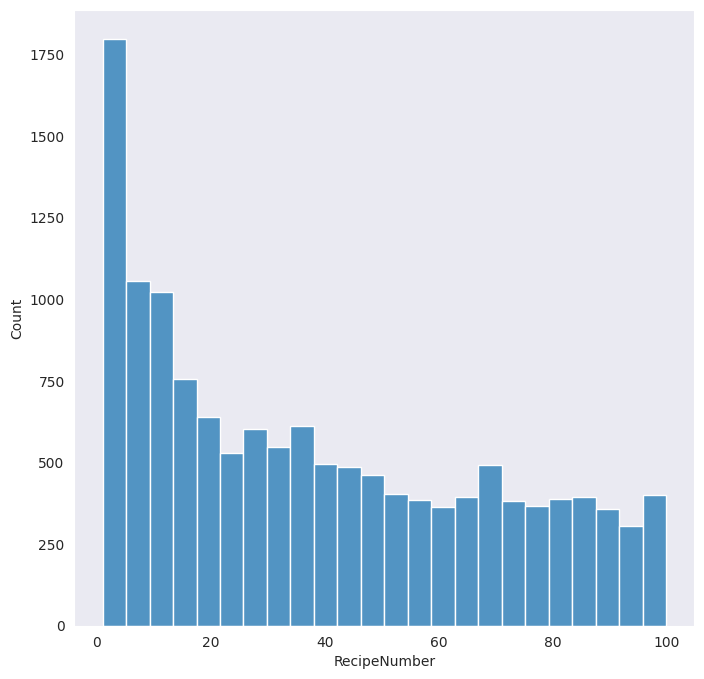

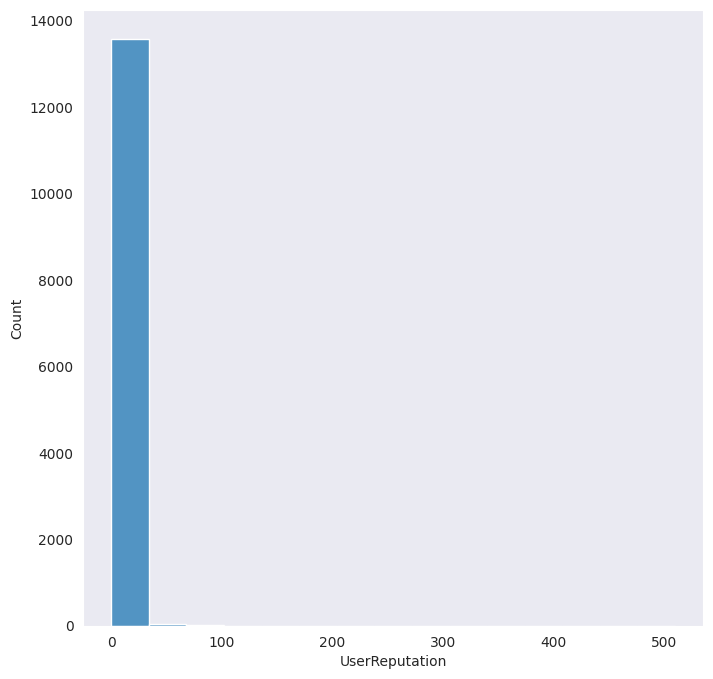

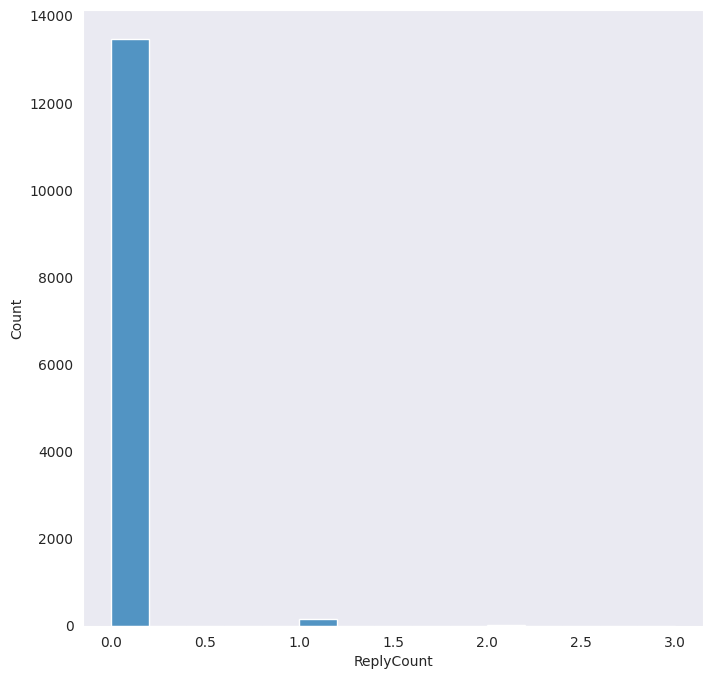

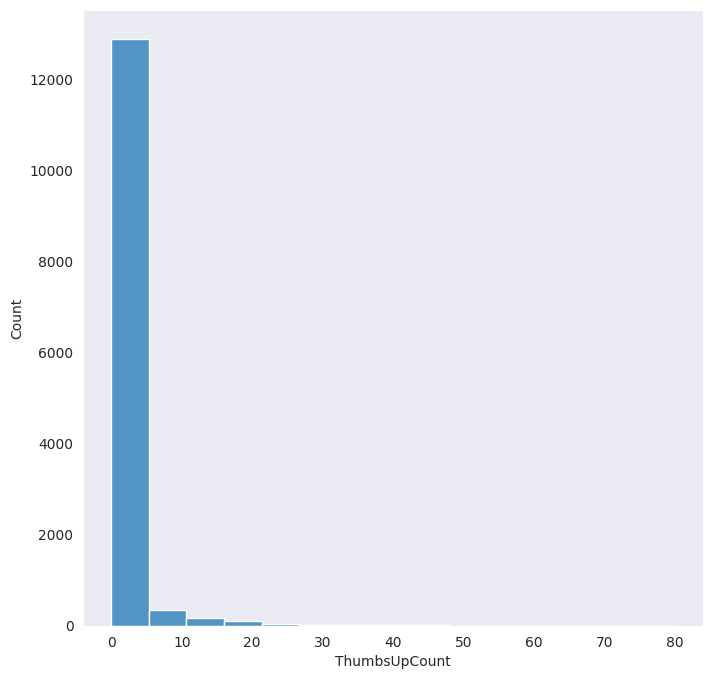

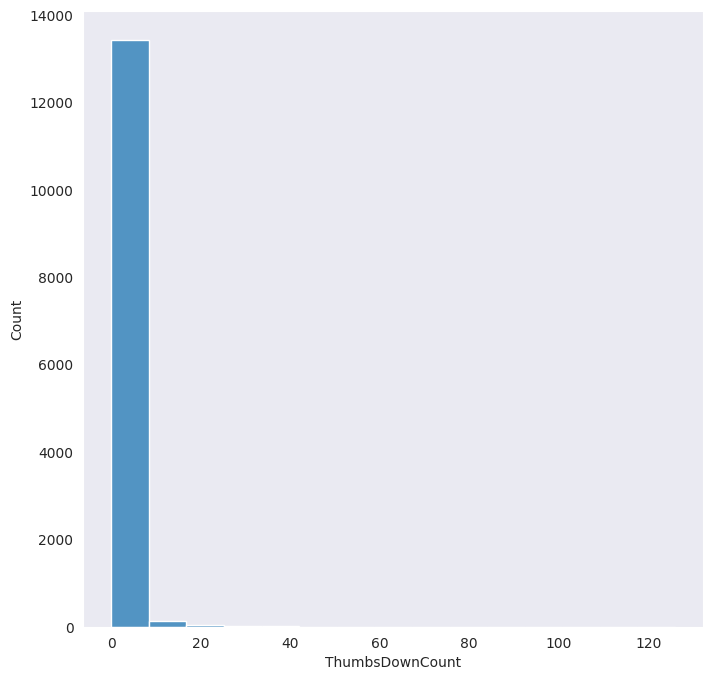

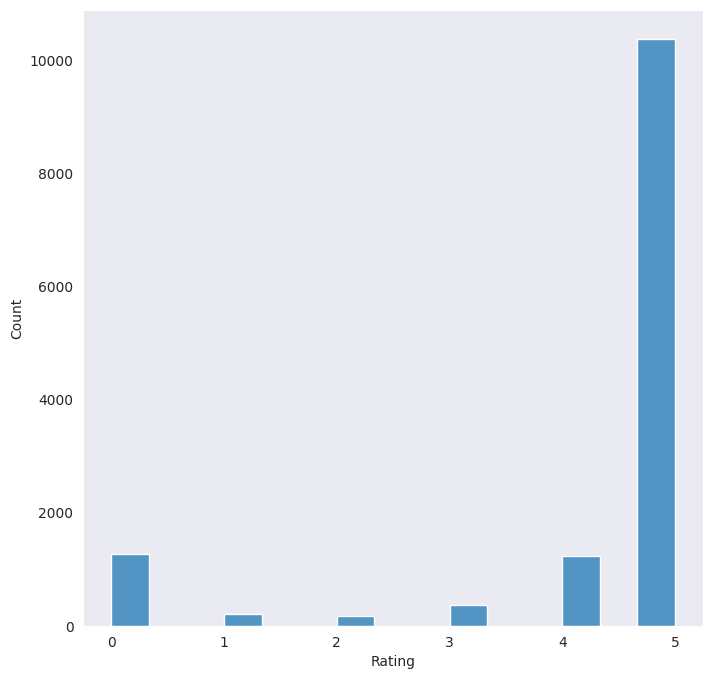

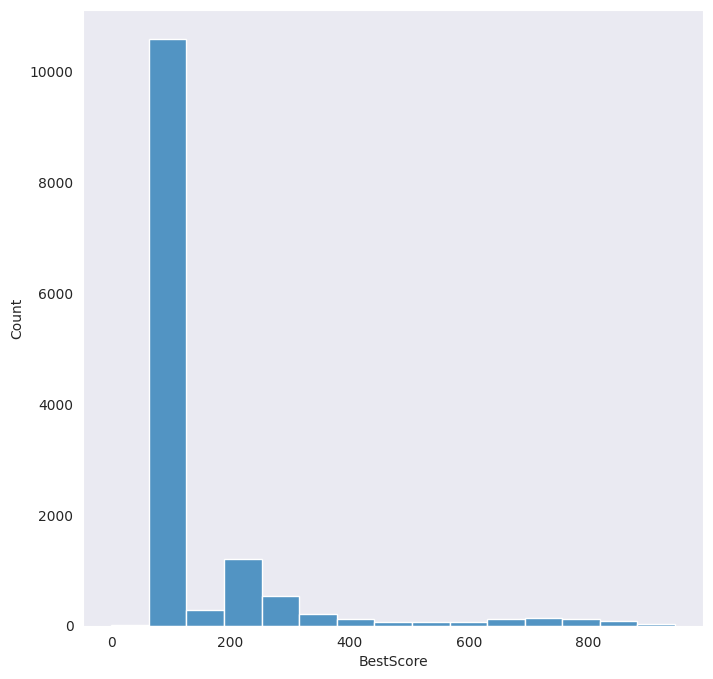

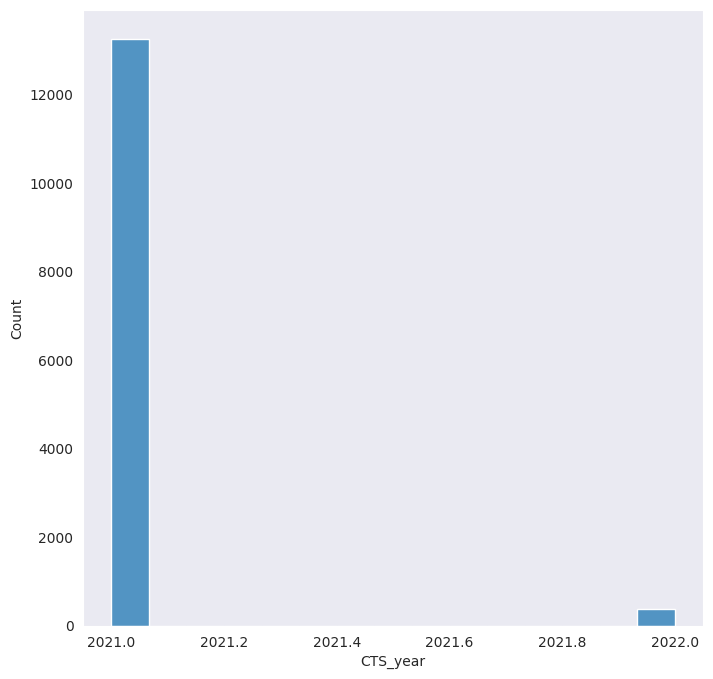

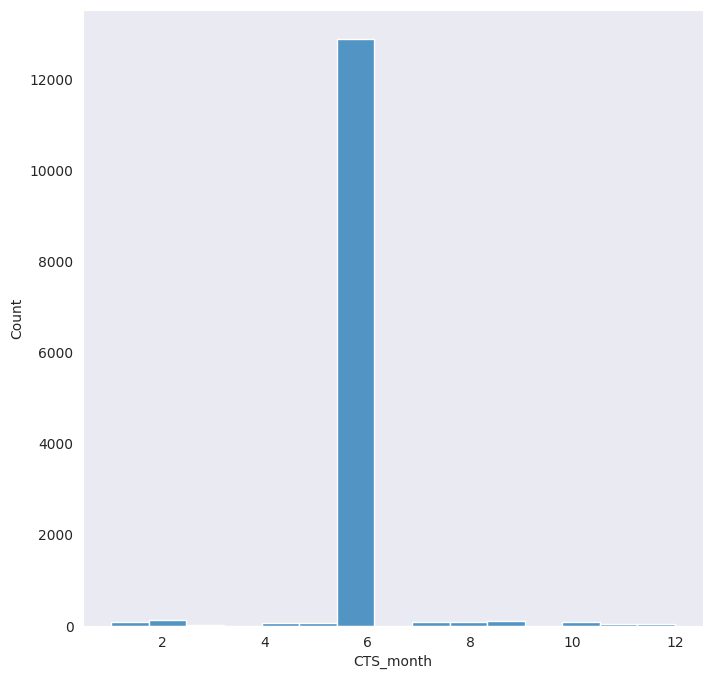

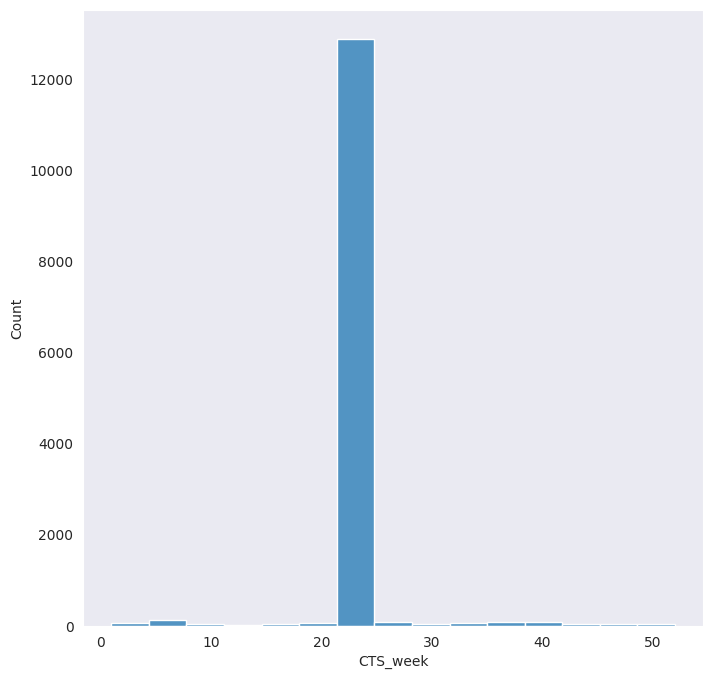

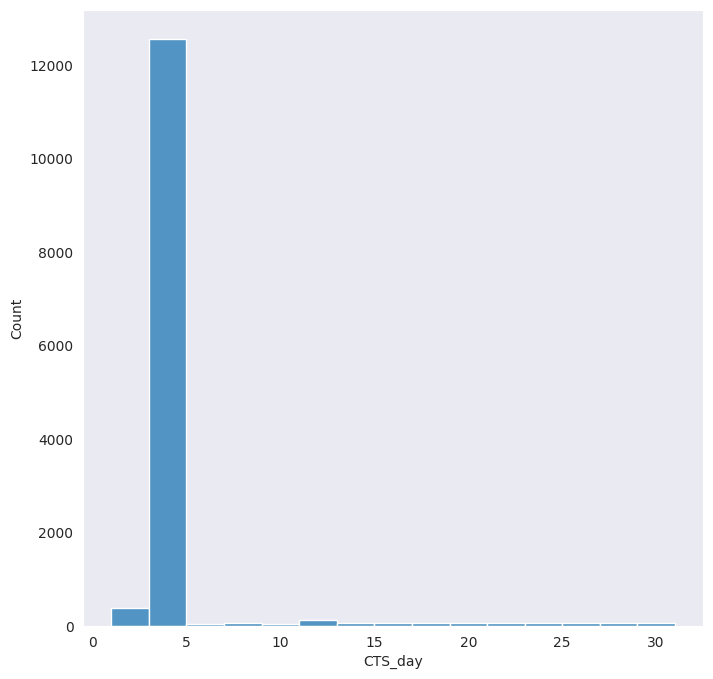

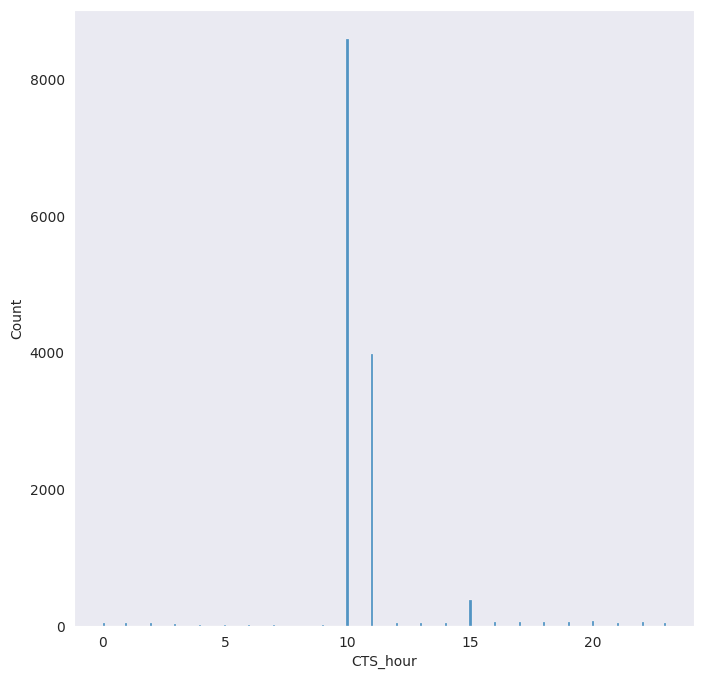

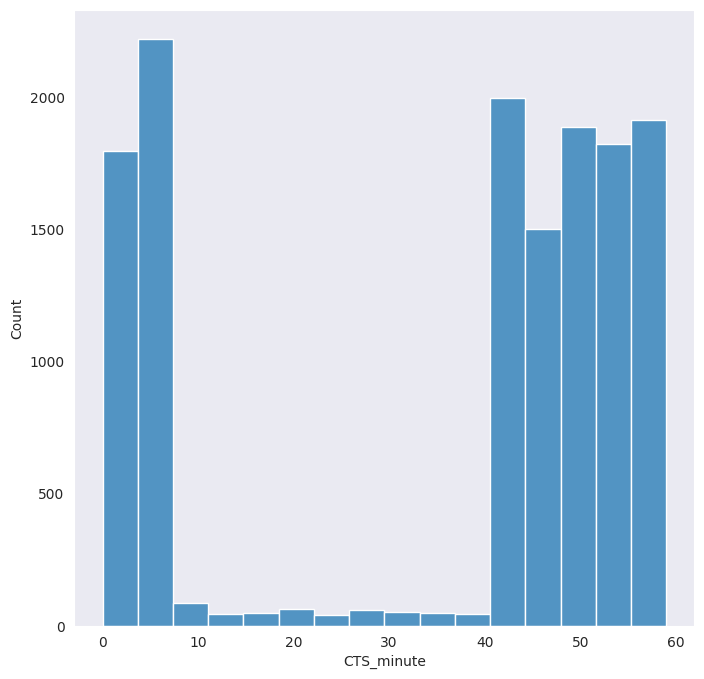

In [14]:
#Plotting histogram to see scale and distribution of data for each feature except Recipe_Review 
for col in cols:
    if col != 'Recipe_Review':
        fig = plt.figure(figsize=(8, 8))
        sns.histplot(data=df, x=col)
        plt.show()

*A few observations based on these plots:*
 > 1. Features are at different scales
 > 2.  Features have different distributions
    

In [33]:
#Quick summary after cleaning and feature engineering
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13634 entries, 0 to 13635
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   RecipeNumber     13634 non-null  int64 
 1   UserReputation   13634 non-null  int64 
 2   ReplyCount       13634 non-null  int64 
 3   ThumbsUpCount    13634 non-null  int64 
 4   ThumbsDownCount  13634 non-null  int64 
 5   Rating           13634 non-null  int64 
 6   BestScore        13634 non-null  int64 
 7   Recipe_Review    13634 non-null  object
 8   CTS_year         13634 non-null  int32 
 9   CTS_month        13634 non-null  int32 
 10  CTS_week         13634 non-null  UInt32
 11  CTS_day          13634 non-null  int32 
 12  CTS_hour         13634 non-null  int32 
 13  CTS_minute       13634 non-null  int32 
dtypes: UInt32(1), int32(5), int64(7), object(1)
memory usage: 1.3+ MB


In [34]:
#Separating the input feature and target variable
X = df.drop('Rating', axis=1)
y = df['Rating']

In [35]:
X.head()

,RecipeNumber,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review,CTS_year,CTS_month,CTS_week,CTS_day,CTS_hour,CTS_minute
0,71,20,0,0,0,100,great recipe! I have made them just as written...,2021,6,22,3,10,44
1,88,1,0,0,1,100,This is an easy and quick recipe that is great...,2021,6,22,3,10,57
2,3,1,0,0,0,100,I think I was looking for something extra spec...,2021,6,22,3,10,49
3,50,1,0,0,0,100,This is our favorite grilled chicken recipe. ...,2021,6,22,2,15,48
4,12,1,0,0,0,100,Great basic recipe. I added 2 teaspoons Tuscan...,2021,6,22,3,11,4


In [36]:
# fig = plt.figure(figsize=(8, 5))
# plt.xlim(0,50)
# sns.kdeplot(data=X)

In [37]:
Counter(y)
(10369/len(y)) *100

76.05251576940003

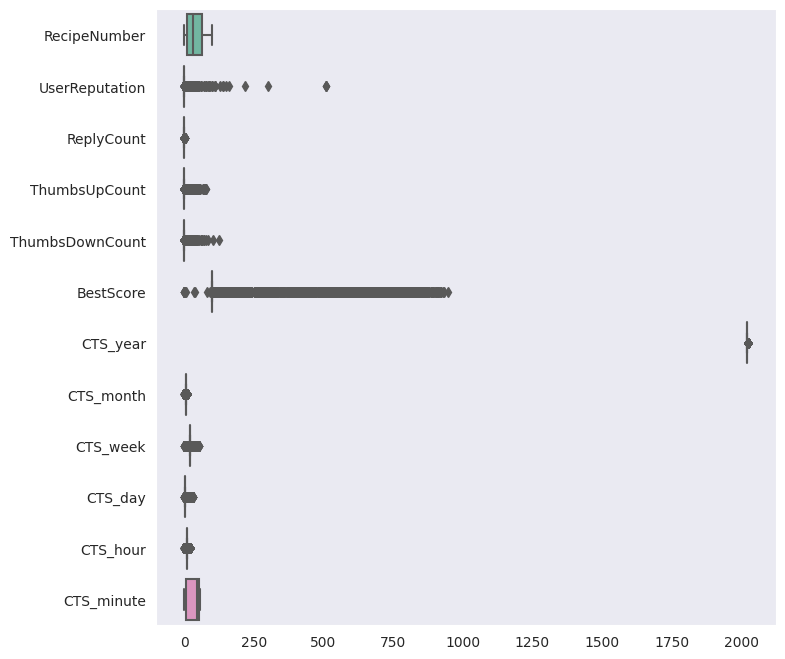

In [38]:
fig = plt.figure(figsize=(8, 8))
ax = sns.boxplot(data=X, orient="h", palette="Set2")

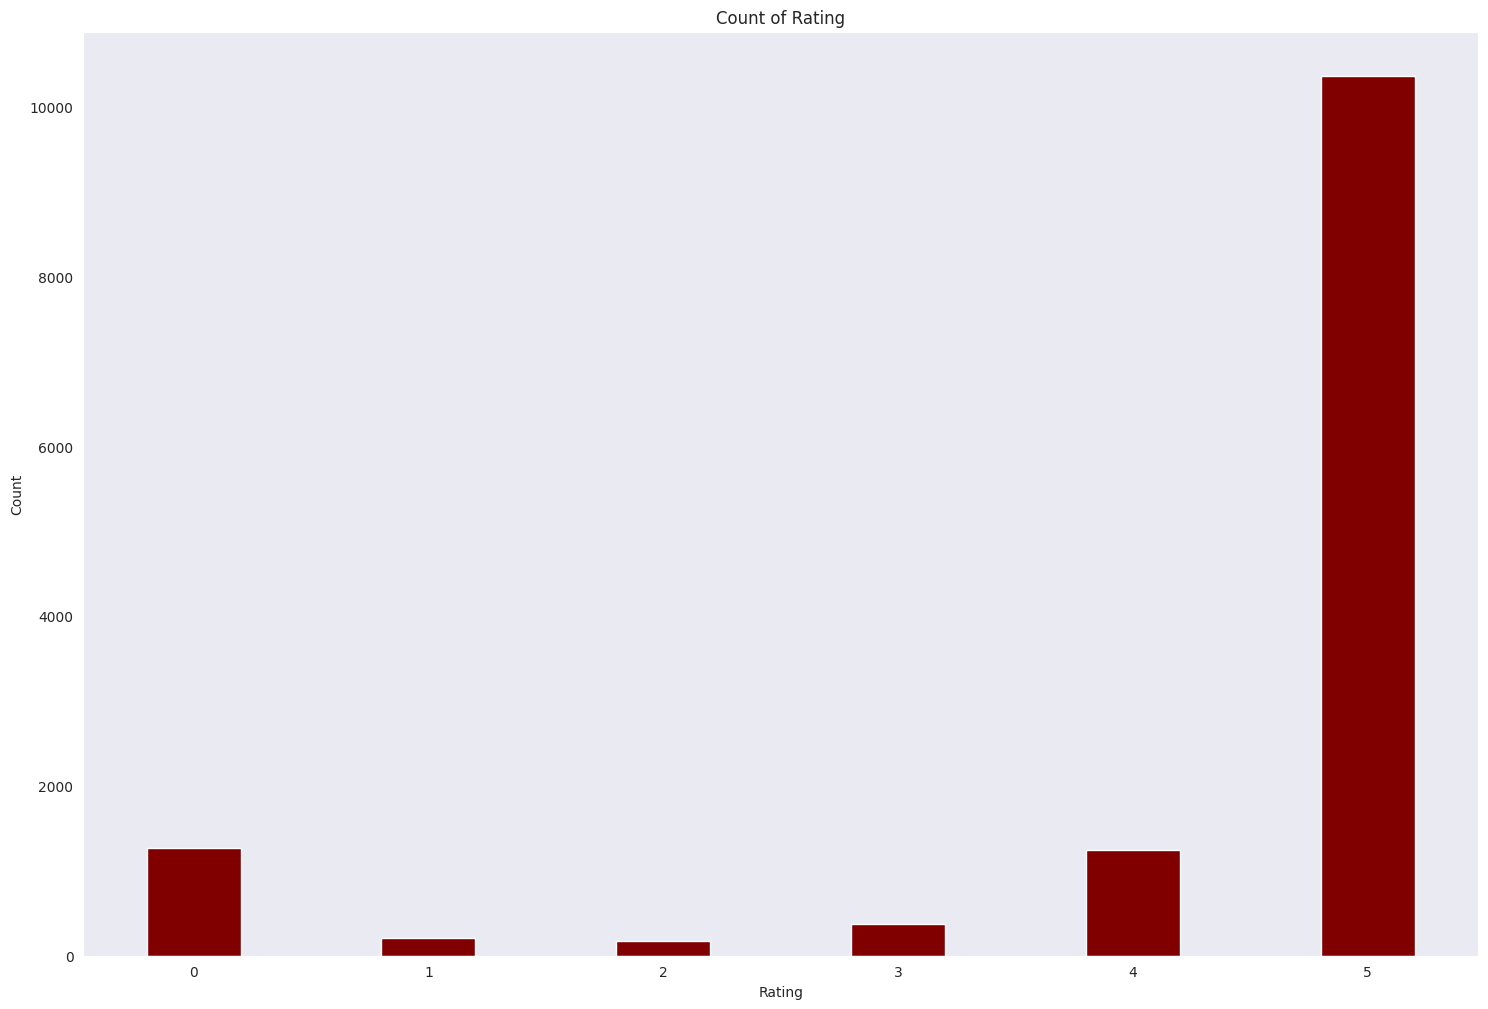

In [39]:
def plot_y(y):
    d = dict(Counter(y))
    plt.bar(x=d.keys(),height=d.values(),color ='maroon', width = 0.4)
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.title("Count of Rating")
    plt.show()


#Plotting distribution of target variable
plot_y(y)

*Observation based on plot*
> Dataset is imbalanced.

In [40]:
# X = X[y != 0] #remove 0
# y = y[y != 0]

# #later try imputer for 0
# # from sklearn.impute import SimpleImputer
# # si = SimpleImputer(missing_values=0, strategy="constant", fill_value=int(np.mean(y)))

# # y = si.fit_transform(np.array(y).reshape(-1,1)).ravel()

In [41]:
#Distribution of classes
Counter(y)

Counter({5: 10369, 0: 1272, 4: 1241, 3: 368, 1: 210, 2: 174})

In [42]:
#Splitting the data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [43]:
#Separating the numerical and categorical columns for preprocessing 
x_train_categorical = X_train['Recipe_Review']
x_train_numerical = X_train.drop('Recipe_Review', axis='columns')

x_val_categorical = X_val['Recipe_Review']
x_val_numerical = X_val.drop('Recipe_Review', axis='columns')

In [44]:
#Encoding the categorical column
tfidf_vectorizer = TfidfVectorizer()
x_train_categorical_vectorized = tfidf_vectorizer.fit_transform(x_train_categorical)
x_val_categorical_vectorized = tfidf_vectorizer.transform(x_val_categorical)

In [49]:
x_train_categorical_vectorized

<12270x9946 sparse matrix of type '<class 'numpy.float64'>'
	with 354388 stored elements in Compressed Sparse Row format>

In [50]:
x_train_categorical_vectorized.toarray() #[:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
#These columns are ordinal in nature -> Encode them to exploit ordinal nature
ordinal = ['UserReputation', 'RecipeNumber', 'BestScore']

In [76]:
#Using labelEncoder to encode them -> Not using for first model Logistic Regression
le = LabelEncoder()
if choose_model_seq != 1:
    x_train_numerical['UserReputation'] = le.fit_transform(x_train_numerical['UserReputation'])
    x_train_numerical['RecipeNumber'] = le.fit_transform(x_train_numerical['RecipeNumber'])
    x_train_numerical['BestScore'] = le.fit_transform(x_train_numerical['BestScore'])
    
    x_val_numerical['UserReputation'] = le.fit_transform(x_val_numerical['UserReputation'])
    x_val_numerical['RecipeNumber'] = le.fit_transform(x_val_numerical['RecipeNumber'])
    x_val_numerical['BestScore'] = le.fit_transform(x_val_numerical['BestScore'])
    

In [28]:
# def fun_replace_outliers(col):
#     Q1 = col.quantile(0.25)
#     Q3 = col.quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     print(Q1,Q3,IQR)
# #     print(col[col < lower_bound])
#     col[col < lower_bound] = lower_bound
#     col[col > upper_bound] = upper_bound
#     return col

# def fun_replace_target_outliers(y):
#     Q1 = np.quantile(y,0.25)
#     Q3 = np.quantile(y,0.75)
#     IQR = Q3 - Q1
#     print(Q1,Q3,IQR)
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
# #     print(y[y < lower_bound])
#     y[y < lower_bound] = lower_bound
#     y[y > upper_bound] = upper_bound
#     return y

# numeric_cols = x_train_numerical.select_dtypes(include=['number'])
# x_train_numerical[numeric_cols.cols] = numeric_cols.apply(fun_replace_outliers)


# numeric_cols = x_test_numerical.select_dtypes(include=['number'])
# x_test_numerical[numeric_cols.cols] = numeric_cols.apply(fun_replace_outliers)


# # y_train = fun_replace_target_outliers(y_train)

In [77]:
#Scaling the data using standard scaler
ss = StandardScaler()
x_train_numerical_scaled = ss.fit_transform(x_train_numerical)
x_val_numerical_scaled = ss.transform(x_val_numerical)

In [78]:
#Putting both the categorical and numerical data together
X_train_stacked = np.hstack([x_train_numerical_scaled, x_train_categorical_vectorized.toarray()])
X_val_stacked = np.hstack([x_val_numerical_scaled, x_val_categorical_vectorized.toarray()])

In [79]:
X_train_stacked.shape, X_val_stacked.shape

((12270, 9958), (1364, 9958))

---

## Model 1 -> **LogisticRegression**
Best Score = 0.77782

In [32]:
log_reg = LogisticRegression(
    penalty='l2',
    C=1.0, fit_intercept=True,
    max_iter=5000,
    solver='lbfgs',
    verbose=1
)
if choose_model_seq == 1:
    log_reg.fit(X_train_stacked, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59754     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19849D+04    |proj g|=  7.28800D+03


 This problem is unconstrained.



At iterate   50    f=  7.83722D+03    |proj g|=  7.33322D+01

At iterate  100    f=  7.49247D+03    |proj g|=  1.05866D+01

At iterate  150    f=  7.46300D+03    |proj g|=  3.30090D+00

At iterate  200    f=  7.46099D+03    |proj g|=  1.42605D+00

At iterate  250    f=  7.46082D+03    |proj g|=  1.07988D+00

At iterate  300    f=  7.46081D+03    |proj g|=  1.17219D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59754    303    326      1     0     0   5.980D-02   7.461D+03
  F =   7460.8066935845563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [33]:
log_reg

LogisticRegression(max_iter=5000, verbose=1)

In [34]:
# # Setup grid hyperparamter search for LogisticRegression
# log_reg_param_grid = {
#     "C": [0.2, 0.5,1,5],
#     "solver": ["sag", "saga", "lbfgs"]
# }

# gsearch_cv = GridSearchCV(
#     LogisticRegression(max_iter=5000),
#     param_grid=log_reg_param_grid,
#     cv=5,
#     verbose=True
# )

# if choose_model_seq == 1:
#     gsearch_cv.fit(X_train_stacked, y_train);
#     print(gsearch_cv.best_estimator_)
#     log_reg = gsearch_cv.best_estimator_

In [35]:
if choose_model_seq == 1:
    # Making predictions on the training set
    y_pred_train = log_reg.predict(X_train_stacked)
    # Making predictions on the validation set
    y_pred_val = log_reg.predict(X_val_stacked)

---

In [80]:
Counter(y_train)

Counter({5: 9333, 0: 1144, 4: 1113, 3: 331, 1: 188, 2: 161})

In [82]:
#Using SMOTE to overcome the class-imbalance
if choose_model_seq != 1:
    sm = SMOTE(sampling_strategy='auto',random_state=42) # auto -> resample all classes but the majority class
    # rus = RandomUnderSampler(random_state=0)
    # cc = ClusterCentroids(random_state=0)

    X_train_stacked, y_train = sm.fit_resample(X_train_stacked, y_train)

In [83]:
Counter(y_train)

Counter({5: 9333, 0: 9333, 2: 9333, 4: 9333, 1: 9333, 3: 9333})

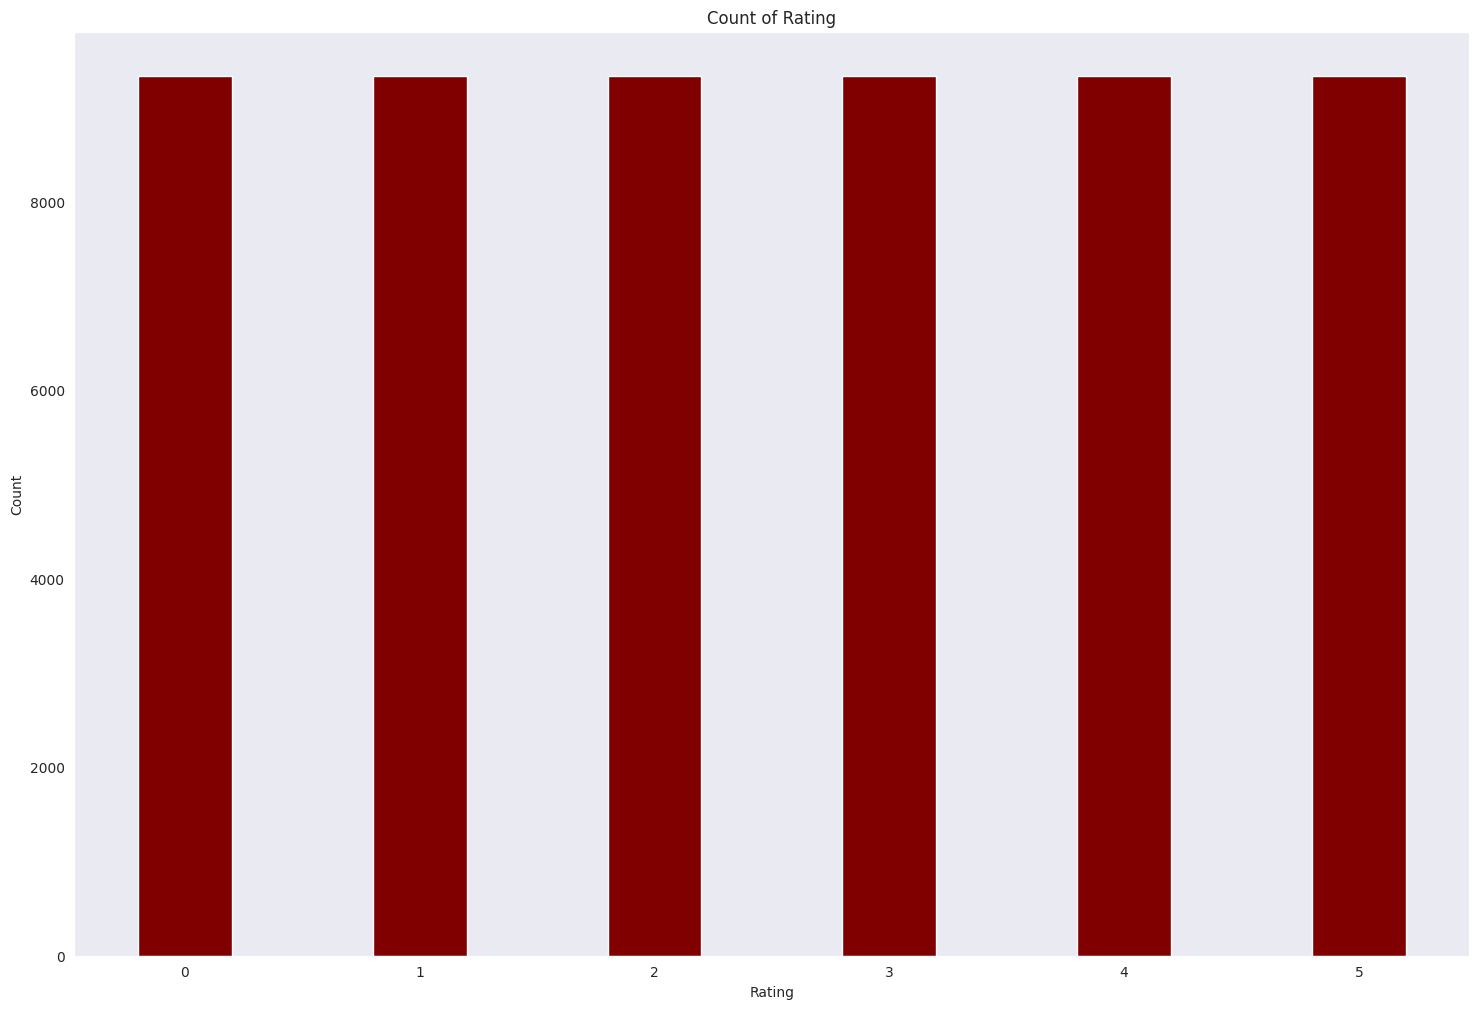

In [84]:
#Plotting distribution of y_train after balancing 
plot_y(y_train)

In [85]:
X_train_stacked.shape, X_val_stacked.shape

((55998, 9958), (1364, 9958))

## Model 2 -> **XGBClassifier**

Best Score:0.754

In [86]:
# model -> 0.754
xgboostclf = XGBClassifier(
 learning_rate =0.08,
 n_estimators=600,
 max_depth=5,   #3
 min_child_weight=4,  #8
 gamma=0.3,  #0.2
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 reg_alpha=0.5,  #0.3
 reg_lambda=0.5,  #0.3
 nthread=4,
 seed=27
)

In [88]:
xgb_clf = Pipeline([
    ("pca",PCA(n_components=405)),  #98% variance
    ("clf",xgboostclf)
])

if choose_model_seq == 2:
    xgb_clf.fit(X_train_stacked, y_train)

In [89]:
xgb_clf

Pipeline(steps=[('pca', PCA(n_components=405)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.08,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=4,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=600,
                               n_jobs=None, nthread=4, num_parallel_tree=None, ...))])

In [97]:
if choose_model_seq == 2:
    print(f"{round(xgb_clf.named_steps['pca'].explained_variance_ratio_.sum() * 100, 4)} % Variance preserved with {xgb_clf.named_steps['pca'].n_components_} components")

98.5104 % Variance preserved with 405 components


In [ ]:
if choose_model_seq == 2:
    plt.plot(np.cumsum((xgb_clf.named_steps['pca'].explained_variance_ratio_)))
    plt.show()

In [43]:
if choose_model_seq == 2:
    # Making predictions on the training set
    y_pred_train = xgb_clf.predict(X_train_stacked)
    # Making predictions on the validation set
    y_pred_val = xgb_clf.predict(X_val_stacked)

---

## Model 3 -> **BaggingClassifier**

Best Score: 0.631

In [99]:
# bg_clf = BaggingClassifier(
#     n_estimators=100, 
#     max_samples=0.5,
#     random_state=0,
#     verbose=1
# )

#---
# kfold = KFold(n_splits = 3,random_state = None)


# initialize the base classifier
base_clf = DecisionTreeClassifier(ccp_alpha=0.0002)

bg_clf = BaggingClassifier(
    base_estimator = base_clf,
    n_estimators = 100,
    max_samples=0.5,
    random_state = 0
)

In [100]:
bg_clf = Pipeline([
    ("pca",PCA(n_components=405)),
    ("clf",bg_clf),
])

##----
# if choose_model_seq == 3:
#     scores = cross_val_score(bg_clf, X_train_stacked, y_train, cv = kfold)
# print(scores)

if choose_model_seq == 3:
    bg_clf.fit(X_train_stacked, y_train)

In [102]:
bg_clf

Pipeline(steps=[('pca', PCA(n_components=405)),
                ('clf',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0002),
                                   max_samples=0.5, n_estimators=100,
                                   random_state=0))])

In [ ]:
# path = bg_clf['clf'].cost_complexity_pruning_path(X_train_stacked, y_train)

In [59]:
# alphas = path['ccp_alphas']
# alphas.mean(), alphas.max()
#(0.0002140218124962079, 0.0356186444999772)


(0.0002140218124962079, 0.0356186444999772)

In [60]:
# for c in [alphas.mean(), alphas.max()]:
#     dt = DecisionTreeClassifier(ccp_alpha=c)
#     dt.fit(X_train_stacked, y_train)
#     y_pred_train = dt.predict(X_train_stacked)
#     # Making predictions on the validation set    
#     y_pred_val = dt.predict(X_val_stacked)
#     print(accuracy_score(y_train, y_pred_train))
#     print(accuracy_score(y_val, y_pred_val))
    

0.8397621343619415
0.5417888563049853
0.16666666666666666
0.093841642228739


In [46]:
if choose_model_seq == 3:
    print(bg_clf.named_steps['pca'].explained_variance_ratio_.sum(), bg_clf.named_steps['pca'].n_components_)

0.9852435059397021 405


In [ ]:
# #HyperParameter Tuning
# param_grid = [
#     {
#         'n_estimators': [10, 50, 100, 500],
#         'max_samples': [0.1, 0.2, 0.5]
#     }
# ]
# scores = ['recall']
# for score in scores:
#     print(f"\nTuning hyperparameters for {score}\n")
    
#     clf_CV = GridSearchCV(
#         BaggingClassifier(), param_grid,
#         scoring = f'{score}_macro',
#         verbose=2, cv=4
#     )
#     print()
#     print("Now Fitting the model")
#     clf_CV.fit(X_train_stacked, y_train)
    
#     print("Best parameters:")
#     print(clf_CV.best_params_)
#     print("Grid scores:")
#     means = clf_CV.cv_results_["mean_test_score"]
#     stds = clf_CV.cv_results_["std_test_score"]
#     for mean, std, params in zip(means, stds,clf_CV.cv_results_['params']):
#         print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")


In [ ]:
# clf_CV.best_estimator_

In [47]:
if choose_model_seq == 3:
    # Making predictions on the training set
    y_pred_train = bg_clf.predict(X_train_stacked)
    # Making predictions on the validation set    
    y_pred_val = bg_clf.predict(X_val_stacked)

---

### Evaluating the Model Performance

In [38]:
print("Training Accuracy : ", accuracy_score(y_train, y_pred_train))
print("Test accuracy : ", accuracy_score(y_val, y_pred_val))

print("\n\nf1 Score")
for avg in ['micro', 'macro']:
    print(avg,"-----")
    print("Training : ", f1_score(y_train, y_pred_train, average=avg))
    print("Validation : ", f1_score(y_val, y_pred_val,average=avg))

print("Classification_report on Training Data")
print(classification_report(y_train, y_pred_train))

print("\nClassification_report on Validation Data")
print(classification_report(y_val, y_pred_val))

Training Accuracy :  0.8114099429502852
Test accuracy :  0.7727272727272727


f1 Score
micro -----
Training :  0.8114099429502852
Validation :  0.7727272727272727
macro -----
Training :  0.4350575628982308
Validation :  0.24846507081562322
Classification_report on Training Data
              precision    recall  f1-score   support

           0       0.78      0.26      0.40      1144
           1       0.78      0.29      0.42       188
           2       0.81      0.16      0.26       161
           3       0.68      0.22      0.33       331
           4       0.68      0.20      0.30      1113
           5       0.82      0.99      0.90      9333

    accuracy                           0.81     12270
   macro avg       0.76      0.35      0.44     12270
weighted avg       0.80      0.81      0.77     12270


Classification_report on Validation Data
              precision    recall  f1-score   support

           0       0.44      0.12      0.20       128
           1       0.00    

On Training Data


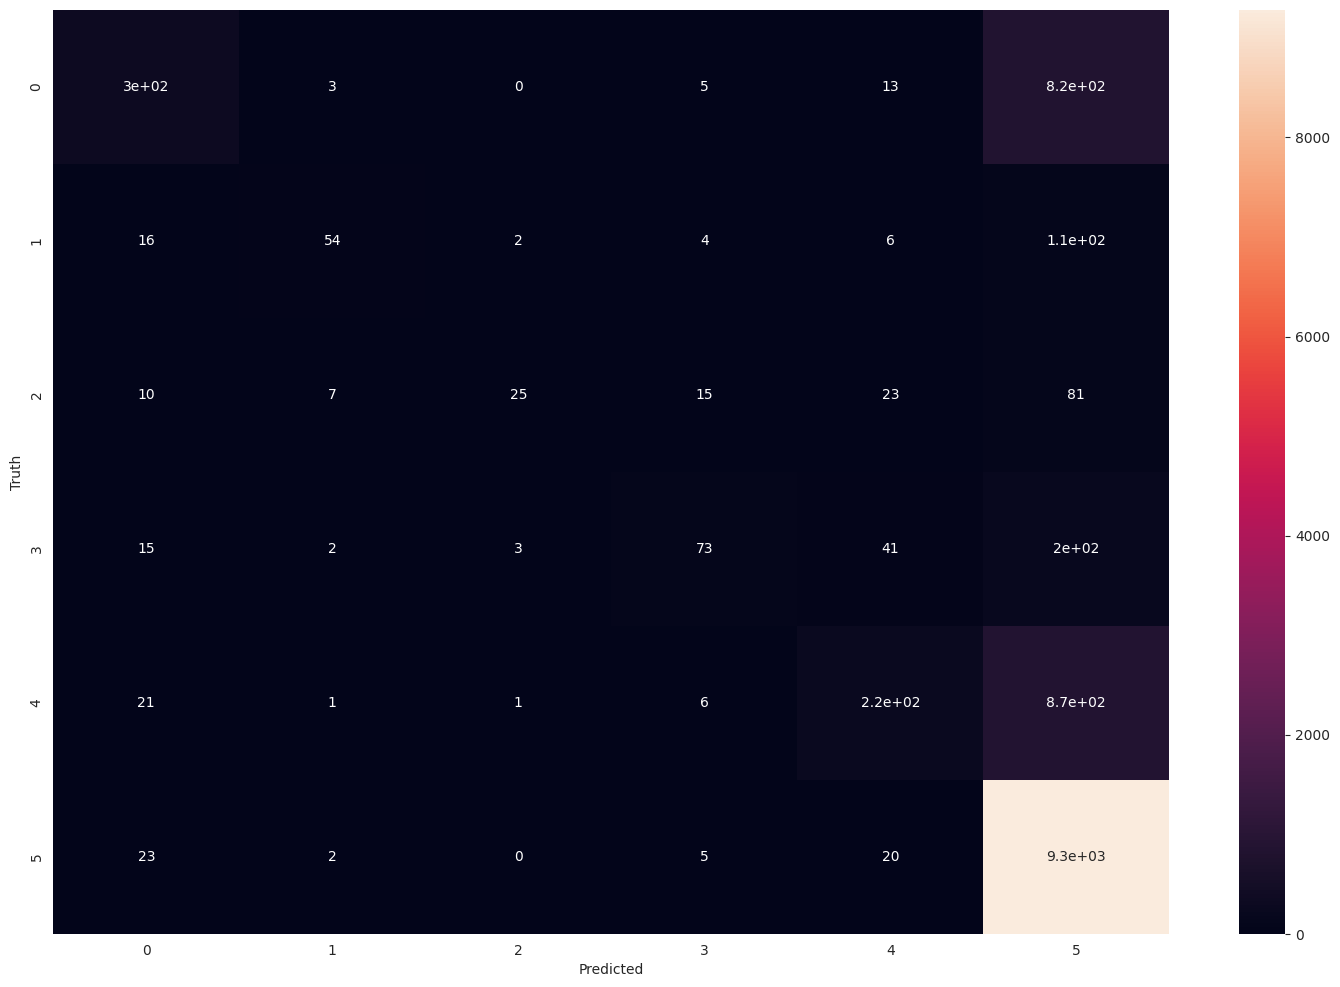

In [39]:
print("On Training Data")
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm,annot=True)
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

On Validation Data


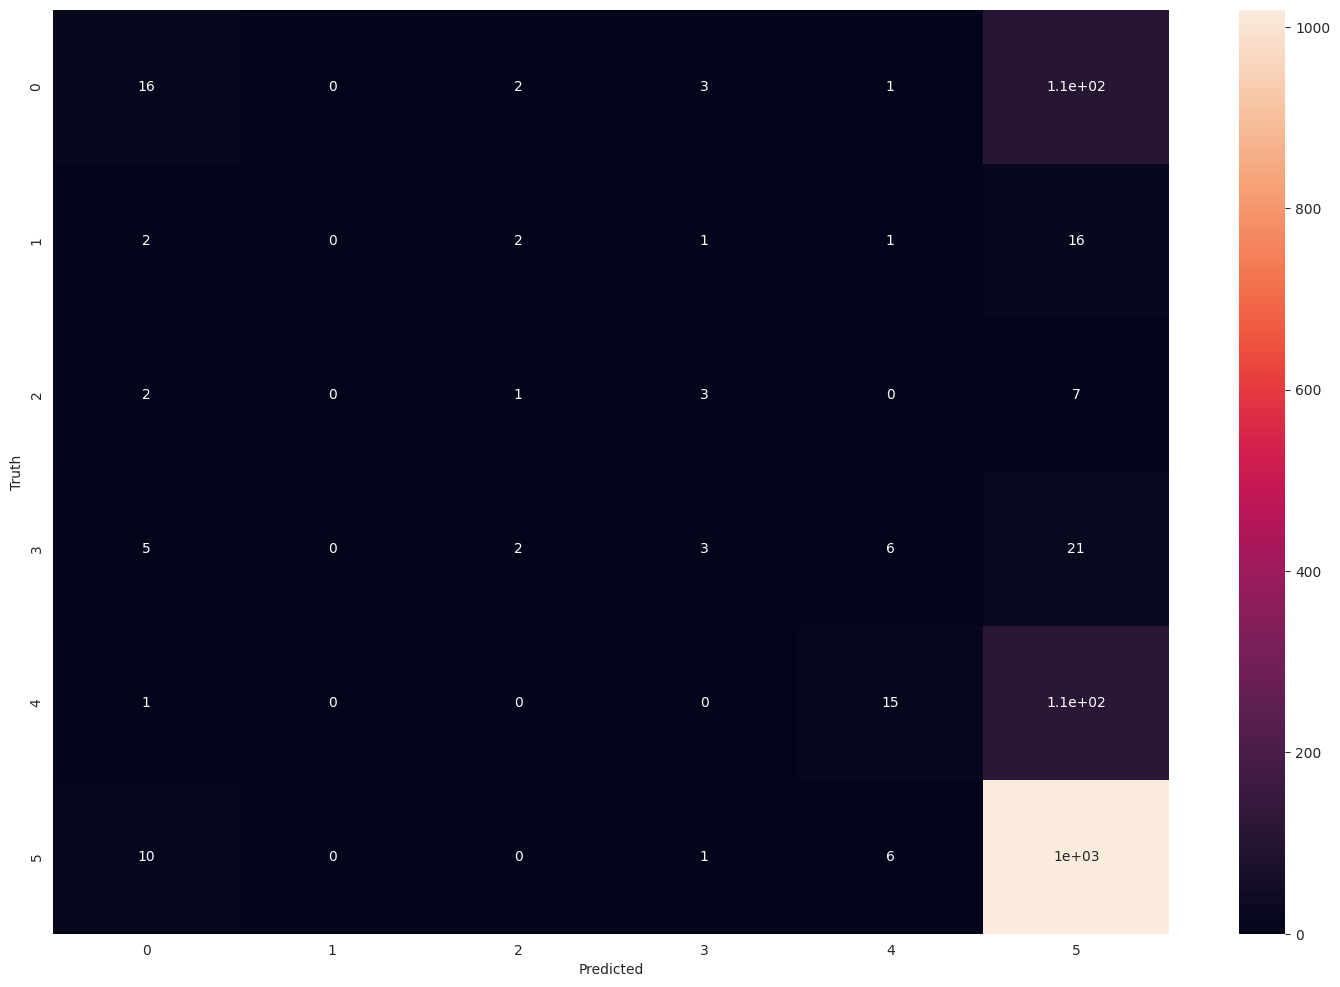

In [40]:
print("On Validation Data")
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm,annot=True)
plt.ylabel("Truth")
plt.xlabel("Predicted")
plt.show()

In [41]:
if choose_model_seq == 1:
    model = log_reg
elif choose_model_seq == 2:
    model = xgb_clf
else:
    model = bg_clf

## Test Data

In [42]:
#Loading the test data
X_test = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

In [43]:
print("Shape: ", X_test.shape)
X_test.isna().sum()

Shape:  (4546, 14)


ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        0
dtype: int64

In [44]:
#Removing the identifier columns from the test data
X_test = X_test.drop(identifiers, axis='columns')
X_test.head()

,RecipeNumber,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,45,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...
1,53,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad...."
2,53,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.
3,89,1,1622648872,0,4,3,212,I made this and followed the instructions as d...
4,70,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...


In [45]:
#Feature engineering -> Transforming the date column
X_test['CreationTimestamp'] = pd.to_datetime(X_test['CreationTimestamp'], unit='s')
 
#CTS = CreationTimestamp
X_test['CTS_year'] = X_test['CreationTimestamp'].dt.year
X_test['CTS_month'] = X_test['CreationTimestamp'].dt.month
X_test['CTS_week'] = X_test['CreationTimestamp'].dt.isocalendar().week
X_test['CTS_day'] = X_test['CreationTimestamp'].dt.day
X_test['CTS_hour'] = X_test['CreationTimestamp'].dt.hour
X_test['CTS_minute'] = X_test['CreationTimestamp'].dt.minute

X_test.drop("CreationTimestamp", axis='columns', inplace=True)

In [46]:
#Separating the categorical and numerical column
X_test_categorical = X_test['Recipe_Review']
X_test_numerical = X_test.drop('Recipe_Review', axis='columns')

In [47]:
if choose_model_seq != 1:
    le = LabelEncoder()
    X_test_numerical['UserReputation'] = le.fit_transform(X_test_numerical['UserReputation'])
    X_test_numerical['RecipeNumber'] = le.fit_transform(X_test_numerical['RecipeNumber'])
    X_test_numerical['BestScore'] = le.fit_transform(X_test_numerical['BestScore'])

In [48]:
#Using the transformers to transform the test data
X_test_categorical_vectorized = tfidf_vectorizer.transform(X_test_categorical)
X_test_numerical_scaled = ss.transform(X_test_numerical)

In [49]:
#Putting both the categorical and numerical data together
X_test_stacked = np.hstack([X_test_numerical_scaled, X_test_categorical_vectorized.toarray()])

In [50]:
#Transforming the test data using pca
if choose_model_seq != 1:
    X_test_stacked = model.named_steps['pca'].transform(X_test_stacked)

In [51]:
#Making predictions on the test data
if choose_model_seq == 1:
    y_pred = model.predict(X_test_stacked)    # I didn't apply PCA for Logistic Regression Model
else:
    y_pred = model.named_steps['clf'].predict(X_test_stacked)

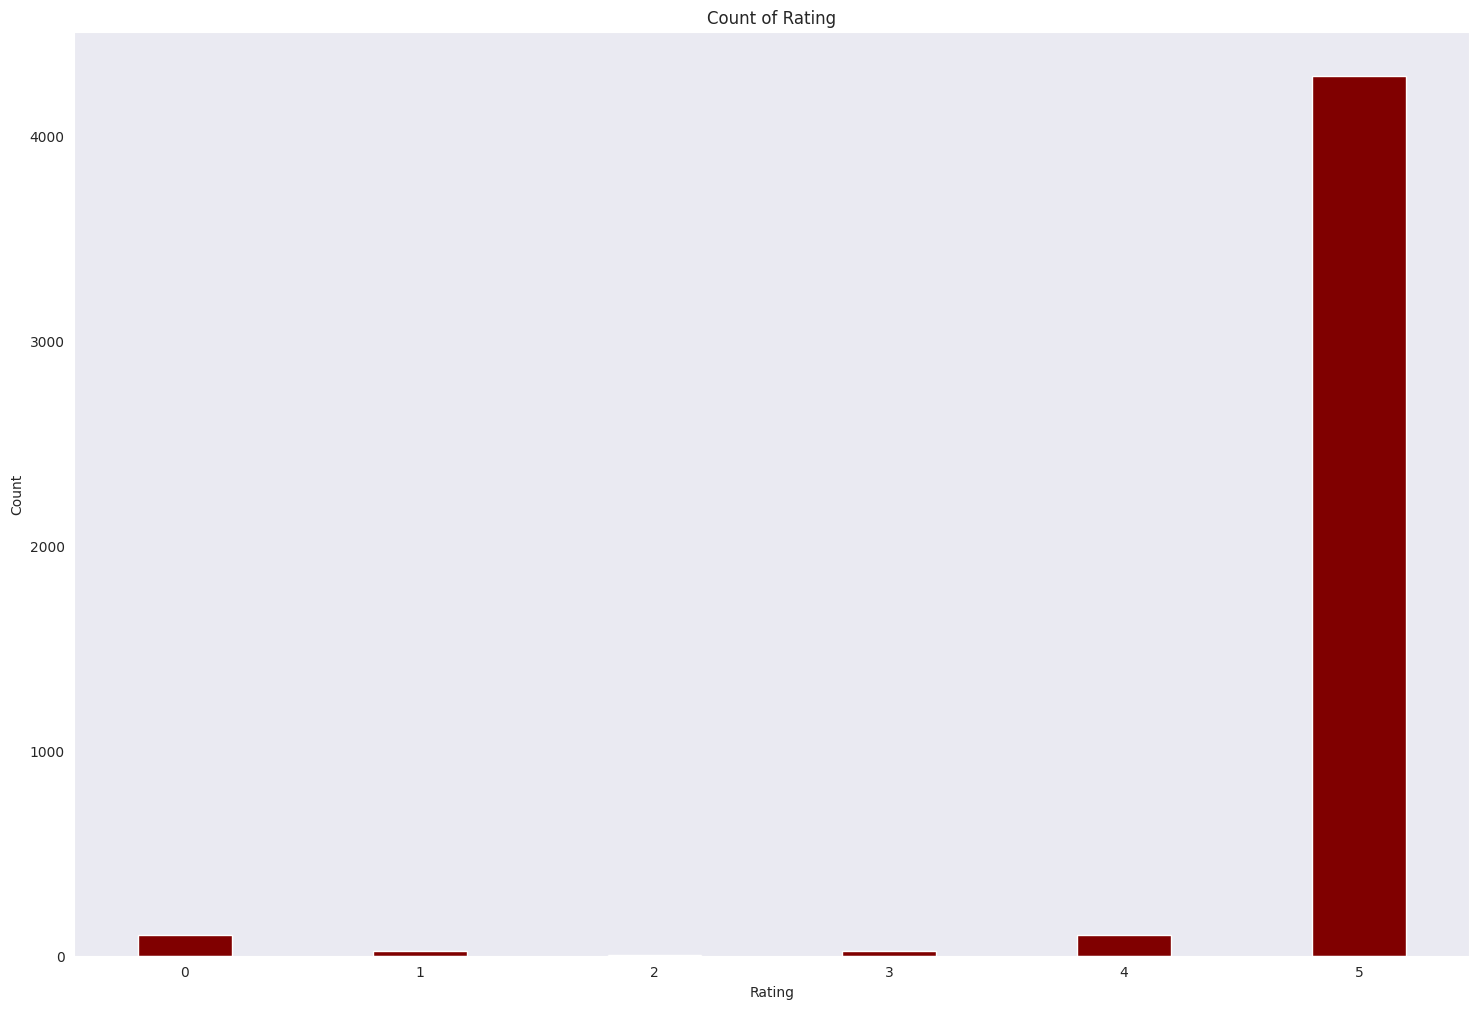

In [52]:
#Distribution of model predictions
plot_y(y_pred)

In [53]:
Counter(y_pred)

Counter({5: 4293, 4: 101, 0: 101, 3: 24, 1: 24, 2: 3})

In [54]:
submission = pd.DataFrame({'ID':range(1, len(y_pred) + 1),
                          'total_amount':y_pred}) 
submission.to_csv('submission.csv', index=False)

## Best Model

In [103]:
#Model Comparison
model_wise_best_score = { 
    "Logistic Regression": [0.77782, log_reg],
    "XGBClassifier": [0.7542, xgb_clf],
    "BaggingClassifier": [0.631, bg_clf]
}

best_model_name = max(model_wise_best_score, key=lambda k: model_wise_best_score[k][0])
best_model = model_wise_best_score[best_model_name][1]
best_score = model_wise_best_score[best_model_name][0]

print("The three models are:")
for (model_name, models) in model_wise_best_score.items():
    print(f'Model Name: {model_name}, Model Best Score: {models[0]:.3f}')
    
print('\nThe best model is "{}" with best score: {:.3f}'.format(best_model_name,best_score))
best_model

The three models are:
Model Name: Logistic Regression, Model Best Score: 0.778
Model Name: XGBClassifier, Model Best Score: 0.754
Model Name: BaggingClassifier, Model Best Score: 0.631

The best model is "Logistic Regression" with best score: 0.778


LogisticRegression(max_iter=5000, verbose=1)